# IMPORTS

In [2]:
import os
import random
import time
import json
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Dropout, 
                                      Flatten, BatchNormalization)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

2025-12-16 21:27:55.930979: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765920476.159672      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765920476.225005      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

TensorFlow Version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# SETUP PATHS

In [6]:
dataset_path = '/kaggle/input/brain-tumor-mri-dataset'
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

baseline_model_path = '/kaggle/input/baseline-model/tensorflow2/default/1'
baseline_results_path = '/kaggle/input/trainresult-of-basline-model/results_summary.json'

In [7]:
print(f"Dataset directory exists: {os.path.exists(dataset_path)}")
print(f"Training directory exists: {os.path.exists(train_dir)}")
print(f"Testing directory exists: {os.path.exists(test_dir)}")

Dataset directory exists: True
Training directory exists: True
Testing directory exists: True


In [9]:
baseline_available = os.path.exists(baseline_model_path)
print(f"\n Baseline model available: {baseline_available}")

if not baseline_available:
    print("To use the baseline model from Notebook 1:")
    print("1. Run the baseline notebook first")
    print("2. In THIS notebook, click 'Add Data' → 'Your Datasets'")
    print("3. Select the output from your baseline notebook")
    print("4. The baseline model will be available for comparison")
else:
    print(f" Baseline model found at: {baseline_model_path}")
    
    # Load baseline results if available
    if os.path.exists(baseline_results_path):
        with open(baseline_results_path, 'r') as f:
            baseline_results = json.load(f)
        print(f" Baseline test accuracy: {baseline_results['test_accuracy']*100:.2f}%")
        print(f" Baseline best val accuracy: {baseline_results['best_val_accuracy']*100:.2f}%")


 Baseline model available: True
 Baseline model found at: /kaggle/input/baseline-model/tensorflow2/default/1
 Baseline test accuracy: 77.65%
 Baseline best val accuracy: 78.36%


# DATA GENERATORS

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.15
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15
)

test_datagen = ImageDataGenerator(rescale=1./255)

train = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=42,
    shuffle=True
)

val = val_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=42,
    shuffle=False
)

test = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

print(f"\nDataset Summary:")
print(f"Training samples: {train.samples}")
print(f"Validation samples: {val.samples}")
print(f"Testing samples: {test.samples}")

Found 4857 images belonging to 4 classes.
Found 855 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.

Dataset Summary:
Training samples: 4857
Validation samples: 855
Testing samples: 1311


# HELPER FUNCTIONS

In [11]:
def create_cnn_model(filters=[64, 128, 256],
                     dropout_rate=0.5,
                     l2_reg=0.001,
                     dense_units=256,
                     input_shape=(128, 128, 3),
                     num_classes=4):
    """Create CNN model for brain tumor classification"""
    model = Sequential(name='BrainTumorCNN')
    
    model.add(Conv2D(filters[0], (3, 3), activation='relu',
                     input_shape=input_shape, padding='same',
                     kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropout_rate * 0.4))
    
    model.add(Conv2D(filters[1], (3, 3), activation='relu',
                     padding='same', kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropout_rate * 0.6))
    
    model.add(Conv2D(filters[2], (3, 3), activation='relu',
                     padding='same', kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropout_rate * 0.8))
    
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu',
                   kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(dense_units // 2, activation='relu',
                   kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

In [12]:
def train_and_evaluate(model, train_gen, val_gen,
                       learning_rate=0.001,
                       optimizer_type='adam',
                       epochs=50,
                       patience=10,
                       verbose=0):
    """Train model and return validation accuracy"""
    
    if optimizer_type == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_type == 'sgd':
        optimizer = SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
    elif optimizer_type == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    early_stop = EarlyStopping(
        monitor='val_accuracy',
        patience=patience,
        restore_best_weights=True,
        mode='max',
        verbose=0
    )
    
    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=patience // 2,
        min_lr=1e-6,
        verbose=0
    )
    
    start_time = time.time()
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=[early_stop, lr_scheduler],
        verbose=verbose
    )
    training_time = time.time() - start_time
    
    best_val_acc = max(history.history['val_accuracy'])
    best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1
    
    return history, best_val_acc, training_time, best_epoch

In [20]:
def evaluate_model(model, test_gen, class_names, model_name="Model"):
    """Evaluate model on test set"""
    print(f"EVALUATING {model_name.upper()}")
    
    y_pred_probs = model.predict(test_gen, verbose=0)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true = test_gen.classes
    
    test_loss, test_acc = model.evaluate(test_gen, verbose=0)
    
    print(f"\n Test Accuracy: {test_acc*100:.2f}%")
    print(f" Test Loss: {test_loss:.4f}")
    
    print("CLASSIFICATION REPORT")
    report = classification_report(y_true, y_pred_classes,
                                   target_names=class_names,
                                   digits=4)
    print(report)
    
    cm = confusion_matrix(y_true, y_pred_classes)
    
    print("PER-CLASS ACCURACY")
    for i, class_name in enumerate(class_names):
        class_acc = cm[i, i] / cm[i, :].sum() if cm[i, :].sum() > 0 else 0
        print(f"  {class_name:15s}: {class_acc*100:.2f}% ({cm[i, i]}/{cm[i, :].sum()})")
    
    return {
        'accuracy': test_acc,
        'loss': test_loss,
        'confusion_matrix': cm,
        'predictions': y_pred_classes,
        'probabilities': y_pred_probs,
        'true_labels': y_true
    }

In [21]:
def plot_training_history(history, title="Training History"):
    """Plot training history"""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    ax1.plot(epochs_range, acc, 'b-o', label='Training', linewidth=2, markersize=4)
    ax1.plot(epochs_range, val_acc, 'r-s', label='Validation', linewidth=2, markersize=4)
    best_epoch = np.argmax(val_acc) + 1
    best_val_acc = max(val_acc)
    ax1.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.5, label='Best')
    ax1.plot(best_epoch, best_val_acc, 'g*', markersize=15)
    ax1.set_xlabel('Epochs', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax1.set_title('Model Accuracy', fontsize=13, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(epochs_range, loss, 'b-o', label='Training', linewidth=2, markersize=4)
    ax2.plot(epochs_range, val_loss, 'r-s', label='Validation', linewidth=2, markersize=4)
    ax2.set_xlabel('Epochs', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Loss', fontsize=12, fontweight='bold')
    ax2.set_title('Model Loss', fontsize=13, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=15, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    print(f"\n Best Validation Accuracy: {best_val_acc*100:.2f}% at epoch {best_epoch}")

In [22]:
def plot_confusion_matrix(cm, class_names, title="Confusion Matrix"):
    """Plot confusion matrix"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
    plt.ylabel('True Label', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

# SIMULATED ANNEALING OPTIMIZER

In [14]:
class SA_Optimizer:
    """Simulated Annealing for CNN hyperparameter optimization"""
    
    def __init__(self, bounds, max_iter=15, temp=1.0, cooling_rate=0.85, step_size=0.1):
        self.bounds = bounds
        self.max_iter = max_iter
        self.initial_temp = temp
        self.cooling_rate = cooling_rate
        self.step_size = step_size
        
        self.history = {
            'iteration': [],
            'temperature': [],
            'score': [],
            'parameters': [],
            'best_score': []
        }
        
        self.best_params = None
        self.best_score = -np.inf

    def generate_initial_solution(self):
        """Generate random initial solution"""
        solution = {}
        for param, (low, high, param_type) in self.bounds.items():
            if param_type == 'continuous':
                solution[param] = np.random.uniform(low, high)
            elif param_type == 'discrete':
                solution[param] = np.random.randint(low, high + 1)
        return solution

    def generate_neighbor(self, current_solution):
        """Generate neighbor solution"""
        neighbor = current_solution.copy()
        param_to_modify = random.choice(list(self.bounds.keys()))
        low, high, param_type = self.bounds[param_to_modify]
        
        if param_type == 'continuous':
            current_val = neighbor[param_to_modify]
            new_val = current_val + np.random.normal(0, self.step_size * (high - low))
            neighbor[param_to_modify] = np.clip(new_val, low, high)
        else:
            current_val = neighbor[param_to_modify]
            step = random.choice([-2, -1, 1, 2])
            new_val = current_val + step
            neighbor[param_to_modify] = int(np.clip(new_val, low, high))
            
        return neighbor

    def evaluate_solution(self, solution, train_gen, val_gen, iteration):
        """Evaluate a solution"""
        model_params = {}
        for param, value in solution.items():
            _, _, param_type = self.bounds[param]
            if param_type == 'discrete':
                model_params[param] = int(round(value))
            else:
                model_params[param] = value

        print(f"  Iter {iteration} | Temp={self.current_temp:.4f} | ", end="")
        print(f"Config=({model_params['filter1']}, {model_params['filter2']}, {model_params['filter3']}, d={model_params['dense_units']}) | ", end="")

        try:
            model = create_cnn_model(
                filters=[model_params['filter1'], model_params['filter2'], model_params['filter3']],
                dropout_rate=model_params['dropout_rate'],
                l2_reg=model_params['l2_reg'],
                dense_units=model_params['dense_units']
            )

            history, val_acc, train_time, best_epoch = train_and_evaluate(
                model,
                train_gen,
                val_gen,
                learning_rate=model_params['learning_rate'],
                optimizer_type='adam',
                epochs=25,
                patience=5,
                verbose=0
            )

            print(f"Acc={val_acc:.4f}")

            del model
            tf.keras.backend.clear_session()

            return val_acc

        except Exception as e:
            print(f"Acc=0.0000 (Error: {str(e)})")
            return 0.0

    def optimize(self, train_gen, val_gen, baseline_score=None):
        """Run SA optimization"""
        print("SIMULATED ANNEALING OPTIMIZATION")
        print(f"Max Iterations: {self.max_iter}")
        print(f"Initial Temp: {self.initial_temp}")
        print(f"Cooling Rate: {self.cooling_rate}")
        if baseline_score:
            print(f"Baseline Score to Beat: {baseline_score*100:.2f}%")

        start_time = time.time()
        
        current_solution = self.generate_initial_solution()
        self.current_temp = self.initial_temp
        
        print("Evaluating initial solution...")
        current_score = self.evaluate_solution(current_solution, train_gen, val_gen, 0)
        
        self.best_score = current_score
        self.best_params = current_solution.copy()
        self._update_history(0, self.current_temp, current_score, current_solution)
        
        print(f"\nInitial Score: {current_score:.4f}")
        if baseline_score and current_score > baseline_score:
            print(f" Already better than baseline!")
        print()

        for iteration in range(1, self.max_iter + 1):
            print(f"ITERATION {iteration}/{self.max_iter}")

            neighbor_solution = self.generate_neighbor(current_solution)
            neighbor_score = self.evaluate_solution(neighbor_solution, train_gen, val_gen, iteration)

            delta = neighbor_score - current_score
            acceptance_prob = np.exp(delta / self.current_temp) if self.current_temp > 0 else 0

            if delta > 0 or random.random() < acceptance_prob:
                current_solution = neighbor_solution
                current_score = neighbor_score
                print(f"  ACCEPTED (Δ={delta:.4f}, P={acceptance_prob:.4f})")
            else:
                print(f"  REJECTED (Δ={delta:.4f}, P={acceptance_prob:.4f})")

            if current_score > self.best_score:
                self.best_score = current_score
                self.best_params = current_solution.copy()
                improvement = ""
                if baseline_score:
                    improvement = f" ({((self.best_score - baseline_score)/baseline_score*100):+.2f}% vs baseline)"
                print(f" NEW BEST: {self.best_score:.4f}{improvement}")

            self.current_temp *= self.cooling_rate
            self._update_history(iteration, self.current_temp, current_score, current_solution)

            print(f"  Current: {current_score:.4f} | Best: {self.best_score:.4f} | Temp: {self.current_temp:.4f}")

        total_time = time.time() - start_time
        print("OPTIMIZATION COMPLETE")
        print(f"Total time: {total_time/60:.2f} minutes")
        print(f"Best validation accuracy: {self.best_score*100:.2f}%")
        if baseline_score:
            improvement = (self.best_score - baseline_score) / baseline_score * 100
            print(f"Improvement over baseline: {improvement:+.2f}%")

        best_params_discrete = {}
        for param, value in self.best_params.items():
            _, _, param_type = self.bounds[param]
            if param_type == 'discrete':
                best_params_discrete[param] = int(round(value))
            else:
                best_params_discrete[param] = value

        print("BEST PARAMETERS")
        for param, value in best_params_discrete.items():
            if isinstance(value, float):
                print(f"  {param:15s}: {value:.6f}")
            else:
                print(f"  {param:15s}: {value}")
        print(f"{'='*60}\n")

        return best_params_discrete, self.best_score

    def _update_history(self, iteration, temperature, score, parameters):
        """Update history"""
        self.history['iteration'].append(iteration)
        self.history['temperature'].append(temperature)
        self.history['score'].append(score)
        self.history['parameters'].append(parameters.copy())
        self.history['best_score'].append(self.best_score)

    def plot_convergence(self, baseline_score=None, save_path=None):
        """Plot SA convergence"""
        fig = plt.figure(figsize=(14, 10))
        
        plt.subplot(3, 1, 1)
        plt.plot(self.history['iteration'], 
                [s*100 for s in self.history['score']], 
                'b-o', alpha=0.7, markersize=6, label='Current Score')
        plt.plot(self.history['iteration'], 
                [s*100 for s in self.history['best_score']], 
                'r-s', linewidth=2, markersize=8, label='Best Score')
        
        if baseline_score:
            plt.axhline(y=baseline_score*100, color='orange', linestyle='--', 
                       linewidth=2, label=f'Baseline ({baseline_score*100:.2f}%)')
        
        plt.xlabel('Iteration', fontsize=12, fontweight='bold')
        plt.ylabel('Validation Accuracy (%)', fontsize=12, fontweight='bold')
        plt.title('Simulated Annealing - Score Convergence', fontsize=14, fontweight='bold')
        plt.legend(fontsize=11)
        plt.grid(True, alpha=0.3)

        plt.subplot(3, 1, 2)
        plt.plot(self.history['iteration'], self.history['temperature'], 
                'g-^', linewidth=2, markersize=6)
        plt.xlabel('Iteration', fontsize=12, fontweight='bold')
        plt.ylabel('Temperature', fontsize=12, fontweight='bold')
        plt.title('Temperature Schedule', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(3, 1, 3)
        score_deltas = [0] + [self.history['score'][i] - self.history['score'][i-1] 
                              for i in range(1, len(self.history['score']))]
        colors = ['green' if d >= 0 else 'red' for d in score_deltas]
        plt.bar(self.history['iteration'], [d*100 for d in score_deltas], color=colors, alpha=0.6)
        plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        plt.xlabel('Iteration', fontsize=12, fontweight='bold')
        plt.ylabel('Score Change (%)', fontsize=12, fontweight='bold')
        plt.title('Score Changes per Iteration', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3, axis='y')

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')

        plt.show()

LOAD BASELINE MODEL

In [15]:
baseline_score = None

if baseline_available:
    print("LOADING BASELINE MODEL FOR COMPARISON")
    try:
        baseline_model = load_model(baseline_model_path)
        print(" Baseline model loaded successfully")
        
        # Evaluate baseline on validation set
        val_loss, val_acc = baseline_model.evaluate(val, verbose=0)
        baseline_score = val_acc
        print(f" Baseline validation accuracy: {baseline_score*100:.2f}%")
    except Exception as e:
        print(f" Could not load baseline model: {e}")
        baseline_score = None

LOADING BASELINE MODEL FOR COMPARISON
 Could not load baseline model: File format not supported: filepath=/kaggle/input/baseline-model/tensorflow2/default/1. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(/kaggle/input/baseline-model/tensorflow2/default/1, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).


RUN SIMULATED ANNEALING


SA Search Space:
  learning_rate  : [0.000100, 0.010000] (continuous)
  dropout_rate   : [0.200000, 0.700000] (continuous)
  l2_reg         : [0.000100, 0.010000] (continuous)
  filter1        : [     32,     128] (discrete)
  filter2        : [     64,     256] (discrete)
  filter3        : [    128,     512] (discrete)
  dense_units    : [    128,     512] (discrete)
SIMULATED ANNEALING OPTIMIZATION
Max Iterations: 8
Initial Temp: 1.0
Cooling Rate: 0.85
Evaluating initial solution...
  Iter 0 | Temp=1.0000 | Config=(36, 64, 482, d=200) | 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1765920970.614603      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1765920978.042613     242 service.cc:1

Acc=0.7029

Initial Score: 0.7029

ITERATION 1/8
  Iter 1 | Temp=1.0000 | Config=(36, 64, 482, d=200) | Acc=0.6316
  ACCEPTED (Δ=-0.0713, P=0.9311)
  Current: 0.6316 | Best: 0.7029 | Temp: 0.8500
ITERATION 2/8
  Iter 2 | Temp=0.8500 | Config=(36, 64, 482, d=200) | Acc=0.7357
  ACCEPTED (Δ=0.1041, P=1.1303)
 NEW BEST: 0.7357
  Current: 0.7357 | Best: 0.7357 | Temp: 0.7225
ITERATION 3/8
  Iter 3 | Temp=0.7225 | Config=(34, 64, 482, d=200) | Acc=0.6281
  ACCEPTED (Δ=-0.1076, P=0.8616)
  Current: 0.6281 | Best: 0.7357 | Temp: 0.6141
ITERATION 4/8
  Iter 4 | Temp=0.6141 | Config=(34, 64, 482, d=200) | Acc=0.7415
  ACCEPTED (Δ=0.1135, P=1.2029)
 NEW BEST: 0.7415
  Current: 0.7415 | Best: 0.7415 | Temp: 0.5220
ITERATION 5/8
  Iter 5 | Temp=0.5220 | Config=(34, 64, 482, d=200) | Acc=0.7871
  ACCEPTED (Δ=0.0456, P=1.0913)
 NEW BEST: 0.7871
  Current: 0.7871 | Best: 0.7871 | Temp: 0.4437
ITERATION 6/8
  Iter 6 | Temp=0.4437 | Config=(34, 64, 482, d=199) | Acc=0.6889
  ACCEPTED (Δ=-0.0982, P=0.80

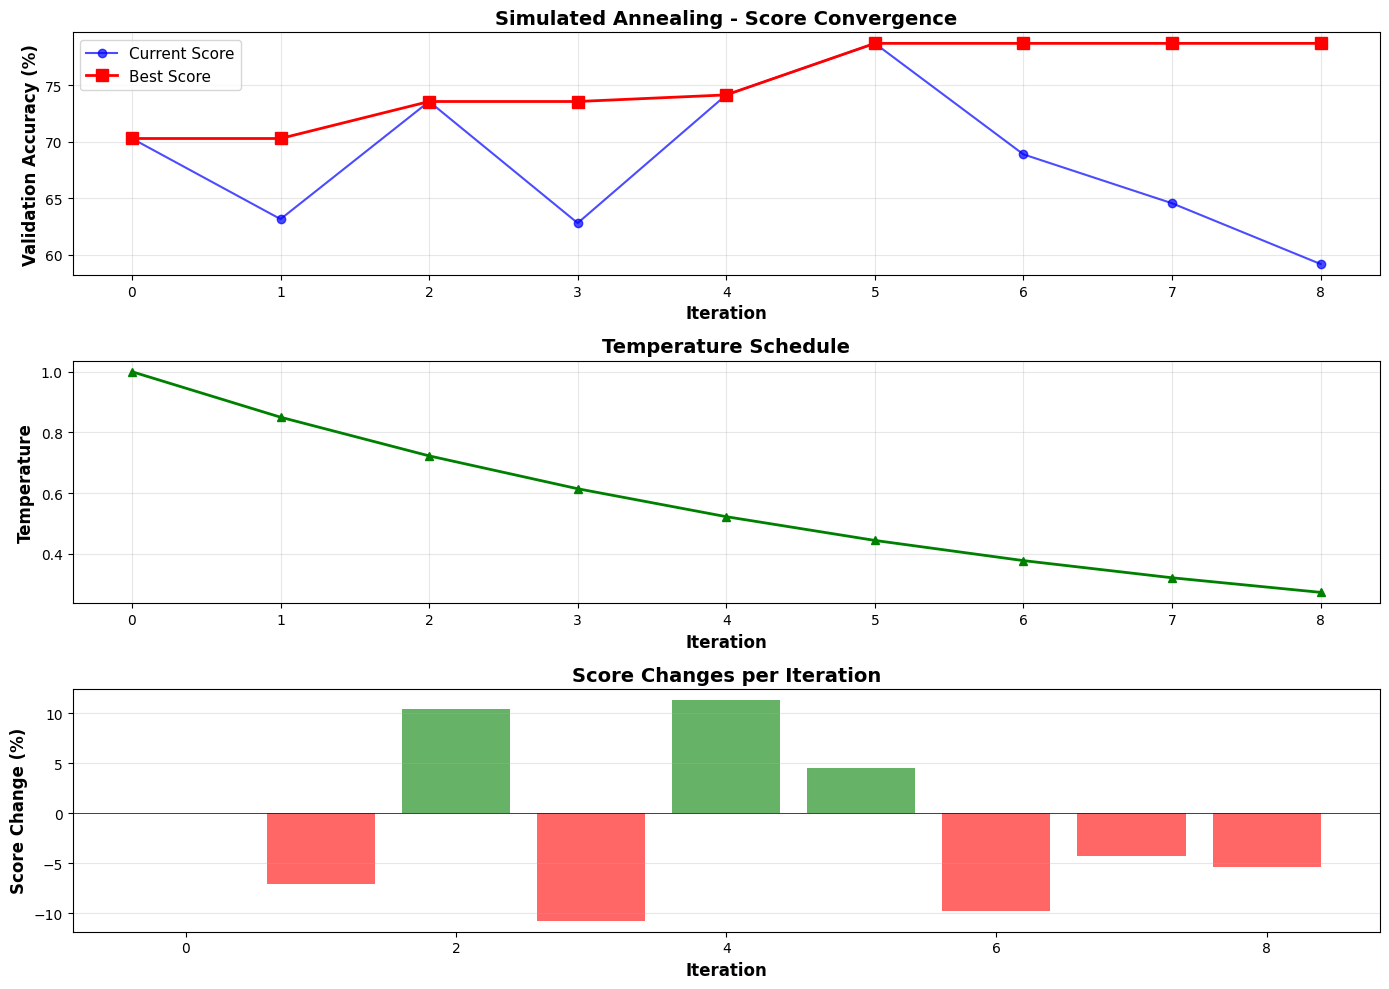

In [16]:
sa_bounds = {
    'learning_rate': (0.0001, 0.01, 'continuous'),
    'dropout_rate': (0.2, 0.7, 'continuous'),
    'l2_reg': (0.0001, 0.01, 'continuous'),
    'filter1': (32, 128, 'discrete'),
    'filter2': (64, 256, 'discrete'),
    'filter3': (128, 512, 'discrete'),
    'dense_units': (128, 512, 'discrete')
}

print("\nSA Search Space:")
for param, (low, high, ptype) in sa_bounds.items():
    if ptype == 'continuous':
        print(f"  {param:15s}: [{low:.6f}, {high:.6f}] ({ptype})")
    else:
        print(f"  {param:15s}: [{low:7d}, {high:7d}] ({ptype})")

sa_optimizer = SA_Optimizer(
    bounds=sa_bounds,
    max_iter=8,
    temp=1.0,
    cooling_rate=0.85,
    step_size=0.1
)

# Run optimization (pass baseline_score for comparison)
best_sa_params, best_sa_score = sa_optimizer.optimize(train, val, baseline_score=baseline_score)

# Plot convergence with baseline comparison
sa_optimizer.plot_convergence(baseline_score=baseline_score, 
                              save_path='/kaggle/working/sa_convergence.png')

TRAIN FINAL MODEL

TRAINING FINAL MODEL WITH OPTIMIZED PARAMETERS


Model: "BrainTumorCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 34)   │           952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128, 128, 34)   │           136 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 34)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64, 64, 34)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 64)     │        19,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 482)    │       278,114 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 482)    │         1,928 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 482)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 16, 16, 482)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 123392)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 200)            │    24,678,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │           404 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,001,338 (95.37 MB)

 Trainable params: 24,999,578 (95.37 MB)

 Non-trainable params: 1,760 (6.88 KB)

Epoch 1/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 54s 282ms/step - accuracy: 0.5216 - loss: 81.4716 - val_accuracy: 0.2550 - val_loss: 6.5663 - learning_rate: 0.0081
Epoch 2/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 34s 222ms/step - accuracy: 0.6278 - loss: 5.0233 - val_accuracy: 0.4444 - val_loss: 4.5587 - learning_rate: 0.0081
Epoch 3/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 35s 228ms/step - accuracy: 0.6128 - loss: 4.0159 - val_accuracy: 0.5906 - val_loss: 5.4877 - learning_rate: 0.0081
Epoch 4/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 34s 225ms/step - accuracy: 0.6275 - loss: 4.3088 - val_accuracy: 0.2409 - val_loss: 5.1834 - learning_rate: 0.0081
Epoch 5/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 34s 222ms/step - accuracy: 0.5942 - loss: 4.4008 - val_accuracy: 0.5380 - val_loss: 4.6591 - learning_rate: 0.0081
Epoch 6/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 35s 227ms/step - accuracy: 0.6120 - loss: 4.3894 - val_accuracy: 0.3930 - val_loss: 5.5341 - learning_rate: 0.0081
Epoch 7/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 34s 224ms/step - accuracy: 0.

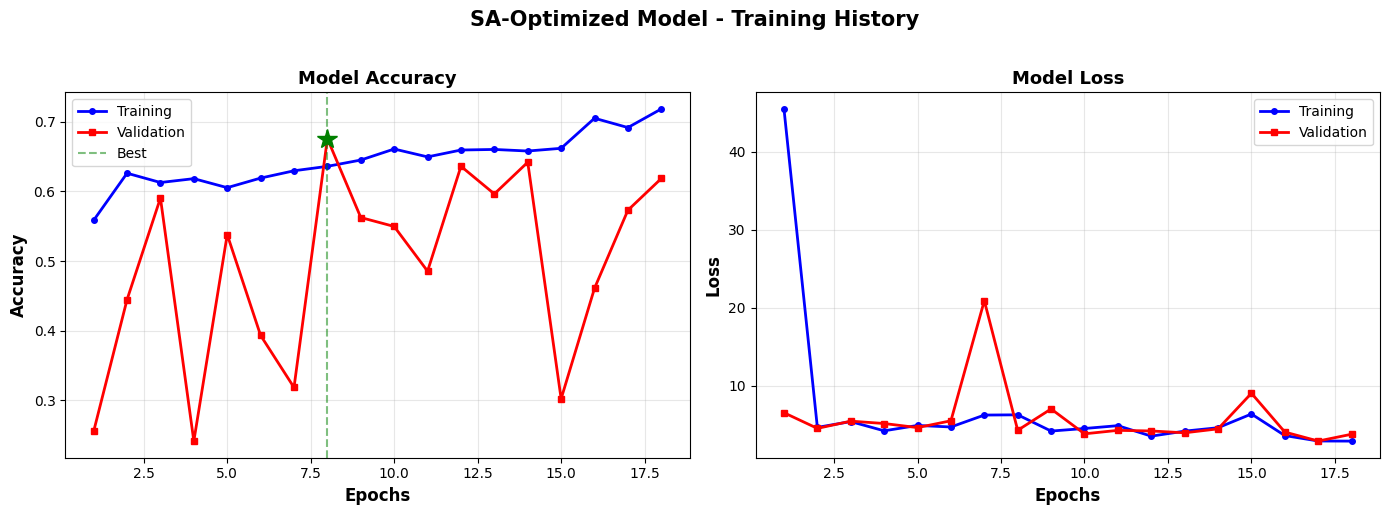


 Best Validation Accuracy: 67.60% at epoch 8


In [25]:
print("TRAINING FINAL MODEL WITH OPTIMIZED PARAMETERS")

sa_model = create_cnn_model(
    filters=[best_sa_params['filter1'], best_sa_params['filter2'], best_sa_params['filter3']],
    dropout_rate=best_sa_params['dropout_rate'],
    l2_reg=best_sa_params['l2_reg'],
    dense_units=best_sa_params['dense_units']
)

sa_model.summary()

sa_history, sa_val_acc, sa_time, sa_epoch = train_and_evaluate(
    sa_model,
    train,
    val,
    learning_rate=best_sa_params['learning_rate'],
    optimizer_type='adam',
    epochs=50,
    patience=10,
    verbose=1
)

print(f"\n Final validation accuracy: {sa_val_acc*100:.2f}% at epoch {sa_epoch}")
if baseline_score:
    improvement = (sa_val_acc - baseline_score) / baseline_score * 100
    print(f" Improvement over baseline: {improvement:+.2f}%")

plot_training_history(sa_history, "SA-Optimized Model - Training History")

EVALUATE ON TEST SET

EVALUATING SA-OPTIMIZED MODEL

 Test Accuracy: 67.81%
 Test Loss: 4.3015
CLASSIFICATION REPORT
              precision    recall  f1-score   support

      glioma     0.6617    0.7433    0.7002       300
  meningioma     0.4257    0.3464    0.3820       306
     notumor     0.8495    0.8642    0.8568       405
   pituitary     0.6709    0.7000    0.6852       300

    accuracy                         0.6781      1311
   macro avg     0.6520    0.6635    0.6560      1311
weighted avg     0.6668    0.6781    0.6708      1311

PER-CLASS ACCURACY
  glioma         : 74.33% (223/300)
  meningioma     : 34.64% (106/306)
  notumor        : 86.42% (350/405)
  pituitary      : 70.00% (210/300)


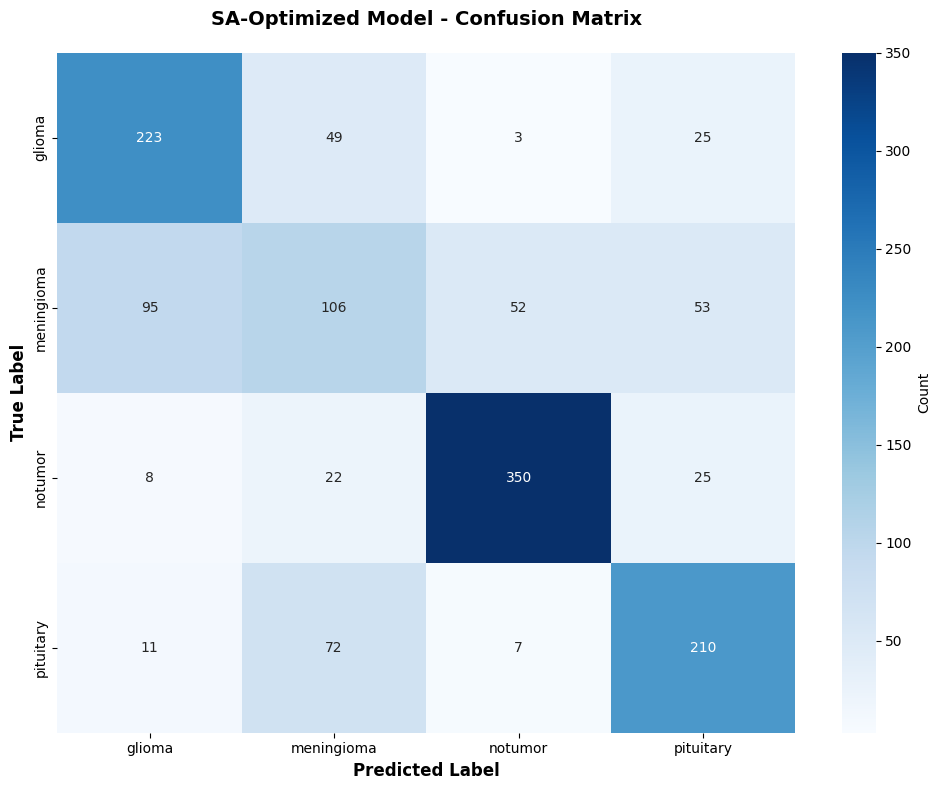

In [26]:
class_names = list(train.class_indices.keys())
sa_results = evaluate_model(sa_model, test, class_names, "SA-Optimized Model")
plot_confusion_matrix(sa_results['confusion_matrix'], 
                     class_names, "SA-Optimized Model - Confusion Matrix")

# Compare with baseline if available
if baseline_available and baseline_score:
    print("BASELINE VS SA-OPTIMIZED COMPARISON")
    
    # Load and evaluate baseline on test set
    baseline_model = load_model(baseline_model_path)
    baseline_test_results = evaluate_model(baseline_model, test, class_names, "Baseline Model")
    
    # Create comparison table
    comparison = pd.DataFrame({
        'Model': ['Baseline', 'SA-Optimized', 'Improvement'],
        'Test Accuracy (%)': [
            baseline_test_results['accuracy'] * 100,
            sa_results['accuracy'] * 100,
            (sa_results['accuracy'] - baseline_test_results['accuracy']) * 100
        ],
        'Val Accuracy (%)': [
            baseline_score * 100,
            sa_val_acc * 100,
            (sa_val_acc - baseline_score) * 100
        ]
    })
    
    print("\n")
    print(comparison.to_string(index=False))
    
    # Plot side-by-side confusion matrices
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    # Baseline confusion matrix
    sns.heatmap(baseline_test_results['confusion_matrix'], annot=True, fmt='d', 
                cmap='Blues', xticklabels=class_names, yticklabels=class_names,
                ax=axes[0], cbar_kws={'label': 'Count'})
    axes[0].set_title(f"Baseline Model\nAccuracy: {baseline_test_results['accuracy']*100:.2f}%", 
                     fontsize=14, fontweight='bold', pad=15)
    axes[0].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('True Label', fontsize=12, fontweight='bold')
    
    # SA-optimized confusion matrix
    sns.heatmap(sa_results['confusion_matrix'], annot=True, fmt='d', 
                cmap='Greens', xticklabels=class_names, yticklabels=class_names,
                ax=axes[1], cbar_kws={'label': 'Count'})
    axes[1].set_title(f"SA-Optimized Model\nAccuracy: {sa_results['accuracy']*100:.2f}%", 
                     fontsize=14, fontweight='bold', pad=15)
    axes[1].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('True Label', fontsize=12, fontweight='bold')
    
    plt.suptitle('Confusion Matrix Comparison', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('/kaggle/working/confusion_matrix_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Plot per-class accuracy comparison
    baseline_class_acc = []
    sa_class_acc = []
    
    for i in range(len(class_names)):
        baseline_cm = baseline_test_results['confusion_matrix']
        sa_cm = sa_results['confusion_matrix']
        
        baseline_acc = baseline_cm[i, i] / baseline_cm[i, :].sum() if baseline_cm[i, :].sum() > 0 else 0
        sa_acc = sa_cm[i, i] / sa_cm[i, :].sum() if sa_cm[i, :].sum() > 0 else 0
        
        baseline_class_acc.append(baseline_acc * 100)
        sa_class_acc.append(sa_acc * 100)
    
    x = np.arange(len(class_names))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bars1 = ax.bar(x - width/2, baseline_class_acc, width, label='Baseline', 
                   color='skyblue', edgecolor='black', linewidth=1.5)
    bars2 = ax.bar(x + width/2, sa_class_acc, width, label='SA-Optimized', 
                   color='lightgreen', edgecolor='black', linewidth=1.5)
    
    ax.set_xlabel('Tumor Type', fontsize=12, fontweight='bold')
    ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax.set_title('Per-Class Accuracy Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/per_class_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

sAVE MODELS AND RESULTS

In [27]:
# Save SA-optimized model
sa_model.save('/kaggle/working/sa_optimized_model.keras')
print("SA-optimized model saved as: /kaggle/working/sa_optimized_model.keras")

# Save best parameters
with open('/kaggle/working/sa_best_parameters.json', 'w') as f:
    # Convert numpy types to native Python types for JSON serialization
    params_to_save = {}
    for key, value in best_sa_params.items():
        if isinstance(value, (np.integer, np.floating)):
            params_to_save[key] = float(value)
        else:
            params_to_save[key] = value
    json.dump(params_to_save, f, indent=2)
print(" Best parameters saved as: /kaggle/working/sa_best_parameters.json")

# Save SA optimization history
sa_history_dict = {
    'optimization': {
        'iterations': sa_optimizer.history['iteration'],
        'temperatures': sa_optimizer.history['temperature'],
        'scores': [float(s) for s in sa_optimizer.history['score']],
        'best_scores': [float(s) for s in sa_optimizer.history['best_score']]
    },
    'training': {
        'accuracy': [float(x) for x in sa_history.history['accuracy']],
        'val_accuracy': [float(x) for x in sa_history.history['val_accuracy']],
        'loss': [float(x) for x in sa_history.history['loss']],
        'val_loss': [float(x) for x in sa_history.history['val_loss']]
    }
}

with open('/kaggle/working/sa_optimization_history.json', 'w') as f:
    json.dump(sa_history_dict, f, indent=2)
print(" Optimization history saved as: /kaggle/working/sa_optimization_history.json")

# Save final results summary
sa_results_summary = {
    'optimization': {
        'algorithm': 'Simulated Annealing',
        'max_iterations': sa_optimizer.max_iter,
        'initial_temperature': sa_optimizer.initial_temp,
        'cooling_rate': sa_optimizer.cooling_rate,
        'best_val_accuracy_during_search': float(best_sa_score),
        'best_parameters': params_to_save
    },
    'final_model': {
        'test_accuracy': float(sa_results['accuracy']),
        'test_loss': float(sa_results['loss']),
        'val_accuracy': float(sa_val_acc),
        'best_epoch': int(sa_epoch),
        'training_time_seconds': float(sa_time)
    },
    'class_names': class_names
}

# Add baseline comparison if available
if baseline_available and baseline_score:
    sa_results_summary['baseline_comparison'] = {
        'baseline_test_accuracy': float(baseline_test_results['accuracy']),
        'baseline_val_accuracy': float(baseline_score),
        'test_accuracy_improvement': float(sa_results['accuracy'] - baseline_test_results['accuracy']),
        'test_accuracy_improvement_percent': float((sa_results['accuracy'] - baseline_test_results['accuracy']) / baseline_test_results['accuracy'] * 100),
        'val_accuracy_improvement': float(sa_val_acc - baseline_score),
        'val_accuracy_improvement_percent': float((sa_val_acc - baseline_score) / baseline_score * 100)
    }

with open('/kaggle/working/sa_results_summary.json', 'w') as f:
    json.dump(sa_results_summary, f, indent=2)
print(" Results summary saved as: /kaggle/working/sa_results_summary.json")

# Save comparison table if baseline available
if baseline_available and baseline_score:
    comparison.to_csv('/kaggle/working/model_comparison.csv', index=False)
    print(" Model comparison saved as: /kaggle/working/model_comparison.csv")

SA-optimized model saved as: /kaggle/working/sa_optimized_model.keras
 Best parameters saved as: /kaggle/working/sa_best_parameters.json
 Optimization history saved as: /kaggle/working/sa_optimization_history.json
 Results summary saved as: /kaggle/working/sa_results_summary.json


FINAL SUMMARY

In [28]:
print("OPTIMIZATION COMPLETE - FINAL SUMMARY")
print(f"\nSA-Optimized Model Performance:")
print(f"  Test Accuracy:       {sa_results['accuracy']*100:.2f}%")
print(f"  Validation Accuracy: {sa_val_acc*100:.2f}%")
print(f"  Training Time:       {sa_time/60:.2f} minutes")
print(f"  Best Epoch:          {sa_epoch}")

if baseline_available and baseline_score:
    print(f"\nComparison with Baseline:")
    print(f"  Baseline Test Acc:   {baseline_test_results['accuracy']*100:.2f}%")
    print(f"  SA-Optimized Test Acc: {sa_results['accuracy']*100:.2f}%")
    test_improvement = (sa_results['accuracy'] - baseline_test_results['accuracy']) / baseline_test_results['accuracy'] * 100
    print(f"  Improvement:         {test_improvement:+.2f}%")
    
    if test_improvement > 0:
        print(f"\n SA optimization successfully improved the model!")
    elif test_improvement > -1:
        print(f"\n Similar performance to baseline")
    else:
        print(f"\n Baseline performed better - consider running more SA iterations")

print(f"\nBest Hyperparameters Found:")
for param, value in best_sa_params.items():
    if isinstance(value, float):
        print(f"  {param:15s}: {value:.6f}")
    else:
        print(f"  {param:15s}: {value}")

print(f"\nSaved Files:")
print(f"  - sa_optimized_model.keras")
print(f"  - sa_best_parameters.json")
print(f"  - sa_optimization_history.json")
print(f"  - sa_results_summary.json")
print(f"  - sa_convergence.png")
if baseline_available and baseline_score:
    print(f"  - model_comparison.csv")
    print(f"  - confusion_matrix_comparison.png")
    print(f"  - per_class_comparison.png")

OPTIMIZATION COMPLETE - FINAL SUMMARY

SA-Optimized Model Performance:
  Test Accuracy:       67.81%
  Validation Accuracy: 67.60%
  Training Time:       10.73 minutes
  Best Epoch:          8

Best Hyperparameters Found:
  learning_rate  : 0.008100
  dropout_rate   : 0.328058
  l2_reg         : 0.008249
  filter1        : 34
  filter2        : 64
  filter3        : 482
  dense_units    : 200

Saved Files:
  - sa_optimized_model.keras
  - sa_best_parameters.json
  - sa_optimization_history.json
  - sa_results_summary.json
  - sa_convergence.png
